## Modelling flow through the homeless services system with a DES model in SimPy (Python)

The DES model of flow through the homeless services system (Singham et al. (2023) illustrates the effects of different development plans (building a mix of temporary shelter and permanent accommodation) on the homeless population involved. This model was built in Simio. We here present a Python DES model of the aggregated version of the model. The motivation for a Python version is two-fold: 

* to facilitate more streamlined running of the model from an optimisation algorithm
* to facilitate easier sharing of the model code with other researchers in future

The Python version uses the SimPy package (documentation [here](https://simpy.readthedocs.io/en/latest/)) which is a DES framework enabling ease of building DES models using standard Python. In short, you start with a SimPy "environment", add resources (i.e. accommodation in our case) and processes (from customers, which request the resources). Then, the SimPy environment is able to manage the event list and and progress though the DES until some stopping criterion is met. Some additional code is required to monitor specific performance measures. Later in this report we discuss the run-time of this Python implementation - it may be that a C++ implementation will be helpful at later stage in the research as this could decrease the run-time - however development of a C++ implementation may be a significant overhead especially since we know of no C++ packages for DES modelling.

The initial build of this Python model is intended to: 

* replicate exactly the aggregate model of Singham et al. (2023) and;
* be flexible to accommodate the re-running of the model with a different solution (different development plan).

Details of the model can by found in the simulation_model.py module which is found in the same folder as this notebook. Below we import this module. 

In [1]:
import simulation_model as sim

### Notation

The terms "accommodation" and "building" are general terms, with "shelter" and "housing" relating to specific types of accommodation/building - with shelter typically being short-term emergency accommodation and housing being long-term accommodation

### Model inputs

Below we specify the model inputs which are needed in order to run the model. Firstly, practical inputs related to running the simulation: 

In [2]:
number_reps = 1000
end_of_simulation = 6 + 63/365 # in years
seed = 1
warm_up_time = 63/365 # in years (this is to allow the first batch of housing/shelter to be built before the customers start arriving)

Next - inputs relating to the initial state of the system

In [3]:
initial_demand = 120
initial_capacity = {'housing' : 40, 'shelter' : 15}

Next - inputs relating to arrival rates and service rates. We model Poisson arrivals with exponential inter-arrival times. The arrival rate is time-dependent and at this stage we consider piecewise constant arrival rates which change annually. We also model a zero service time for shelter and an exponentially distributed service time for housing with mean equal to that of the Triangular distribution used by Singham et al (2023). For now we consider these arrival and service rate models as fixed inputs to the simulation model based on the best estimates of the true arrival and service rates. In future we will plan to study the implications of uncertainty in these input models. 

In [4]:
arrival_rates = [35.0400, 42.0048, 46.2528, 46.2528, 41.6100, 37.4052] # in 1/year. One constant rate per year.
service_mean = {'housing' : (1/52)*(0+300+400)/3, 'shelter' : 0.0} # in years

# adjust arrival rates to include re-entries
reentry_rate = 0.17 # the proportion of those leaving accommodation which re-enter the system some time later
arrival_rate_reentries = (initial_capacity['housing']*reentry_rate)/service_mean['housing'] # assuming re-entries from the initial number of servers
arrival_rates = [i+arrival_rate_reentries for i in arrival_rates]#
print(arrival_rates)

[36.55542857142857, 43.520228571428575, 47.76822857142857, 47.76822857142857, 43.12542857142857, 38.92062857142857]


Next the inputs relating to the building of new accommodation - these cover the "solution" which we are looking to improve. There are three inputs here, only one of which (build_rates) which we treat as the solution, which we now explain: 

The **time between changing the build rate** is considered to be the minimum time for which it is practical for local county administration (and any associated building contractors) to change the rate at which they are building. If this time was infinitessimally small, then a build rate, as a function of time, could be a continuous function of time. However, in practice, local county administration are likely to only change the rate of building at fixed intervals. 

Given the time between changes to the build rate, we then specify those **build rates** for both housing and shelter. The rates are constant in between the changes. The number of build rates we need (and thus the dimensionality of the problem) is determined by $2 \frac{\text{end_of_simulation}}{\text{time_btwn_changes_in_build_rate}}$. We allow each build rate to be continuous-valued in order to capture a wider range of possible building rates. However, as described next, we only allow whole numbers of accommodation units to be built. 

The **time between building**: with a continuous-valued build rate, we stipulate that at regular intervals, given the preceding rate of building, accommodation units are opened and ready for use. This makes sense in practice - if there is work on a building site where housing is built at an average rate of 1 unit per day, it is unlikely that one house will be ready to be opened each day. Instead, at the end of a fixed period, given the building that has taken place, a number of accommodation units open. At the point of opening units of accommodation, given the preceding build rate and elapsed time, there may be a non-integer number of units available - in this case we open the integer number of houses, and carry over the fractional amount into the next period. Because of this, if the simulation ran forever, very small changes to the build rate would eventually have a material effect, however since the simulation does not run forever, a small change may not have a material effect on the output of the model. 

*Worked example*: 

In [5]:
time_btwn_changes_in_build_rate = (63*6)/365 # in years
build_rates = {'housing' : [18, 36, 42, 60, 48, 24], 'shelter' : [12, 12, 0, -12, -6, -6]} # in 1/year
time_btwn_building = 63/365 # in years. 63/365 years = 9 weeks.

In [6]:
output = sim.simulate(end_of_simulation, 
                      number_reps, 
                      time_btwn_building, 
                      time_btwn_changes_in_build_rate, 
                      initial_capacity, 
                      service_mean, 
                      arrival_rates, 
                      build_rates, 
                      initial_demand, 
                      seed,
                      warm_up_time)

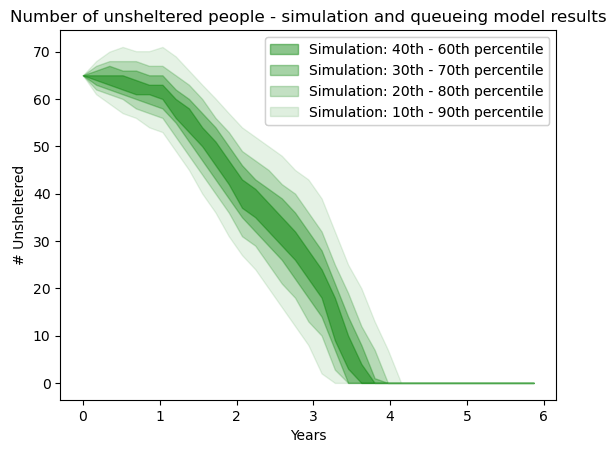

In [7]:
fig, ax = sim.create_fanchart(output)

In [12]:
# imports
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

# read simulation data from file
data_sim = []
unsheltered_initial = initial_demand - initial_capacity['shelter'] - initial_capacity['housing'] # to add to the first row of each data file

for i in range(1000):
    run = i+1
    file_name = 'data/simio_outputs/2023-08-11-SimpleModelAC_IncV2_no_absorbing_state/SimOutput_Experiment1_Scenario 4_Rep' + str(run) + '.xlsx'
    sim_out = pd.read_excel(file_name)
    sim_out.columns = ['housing_capacity', 'shelter_capacity', 'housing_occupied', 'shelter_occupied', 'num_unsheltered', 'last_shetler_time']
    data_sim.append(np.array(pd.concat([pd.Series([unsheltered_initial]), sim_out['num_unsheltered'][1:]])))
    
data_sim = np.array(data_sim).T

In [13]:
def compare_cdf(data_simpy, data_simio, yr):
    """
    Function to display a chart comparing CDFs of the analytical queuing model output for #unsheltered with ecdf
    
    Parameters
    ----------
    data_simpy : nparray
        simulation output from simpy
    data_simio : nparray
        simulation output from simio
    yr : int
        the year to look at.       

    Returns
    -------
    fig, ax : plot objects
    
    """
    
    # simulation data simpy
    x1 = np.sort(data_simpy[yr*6])
    simpy_out = np.arange(len(x1))/float(len(x1))

    # simulation data simio
    x2 = np.sort(data_simio[yr*6])
    simio_out = np.arange(len(x2))/float(len(x2))
    
    fig, ax = plt.subplots()
    line1, = ax.plot(x1, simpy_out, color = 'black', linewidth = 1)
    line2, = ax.plot(x2, simio_out, color = 'blue', linewidth = 1)
    plt.xlabel('# Unsheltered')
    plt.ylabel('Probability')
    plt.title('CDF for number unsheltered after year ' +  str(yr))
    first_legend = plt.legend(['SimPy model','Simio model'])
    ax.add_artist(first_legend)
    
    return fig, ax


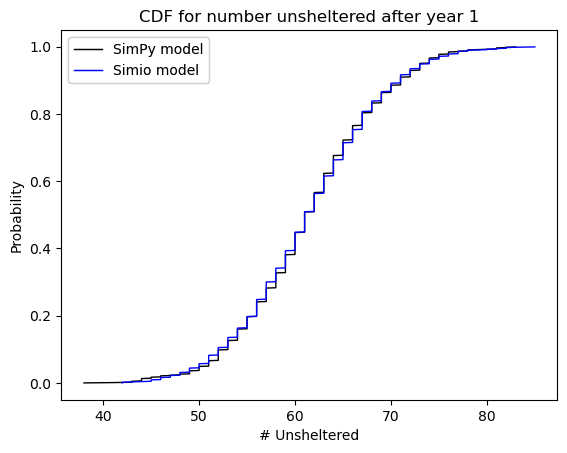

In [15]:
fig, ax = compare_cdf(output, data_sim,1)

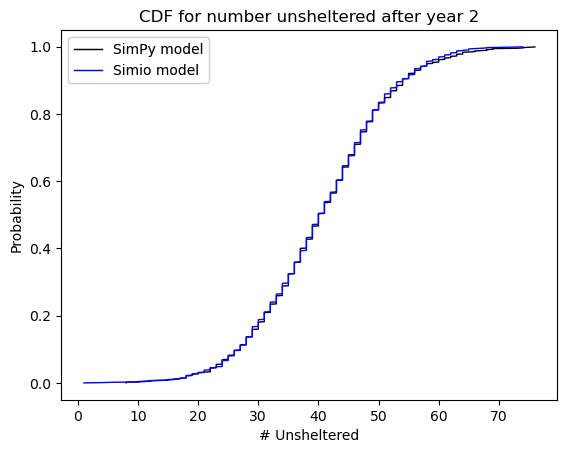

In [16]:
fig, ax = compare_cdf(output, data_sim,2)

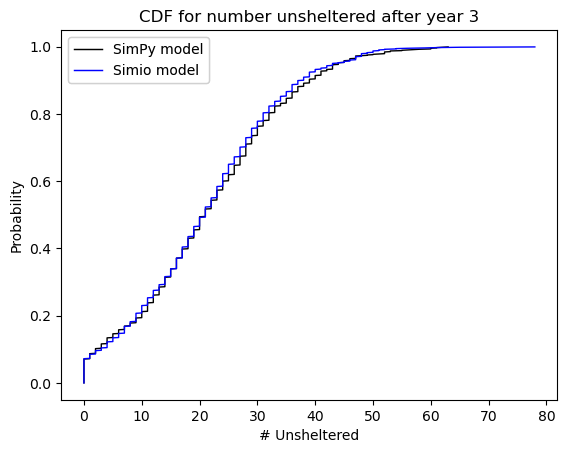

In [17]:
fig, ax = compare_cdf(output, data_sim,3)